In [7]:
import pandas as pd
import numpy as np
import itertools

Q = 1.0
T = 1.0

class Game(object):
    def __init__(self,df):
        self.df = df                                                 # df = dataframe
        self.df_capability = df.Capability.to_dict()    
        self.df_position = df.Position.to_dict()    
        self.df_salience = df.Salience.to_dict()    
        self.max_pos = df.Position.max()
        self.min_pos = df.Position.min()

    def weighted_median(self):                                       # Median Voter Calculation
        self.df['w'] = self.df.Capability*self.df.Salience           # power 
        self.df['w'] = self.df['w'] / self.df['w'].sum()
        self.df['w'] = self.df['w'].cumsum()
        return float(self.df[self.df['w']>=0.5].head(1).Position)

    def mean(self):
        return (self.df.Capability*self.df.Position*self.df.Salience).sum() / \
               (self.df.Capability*self.df.Salience).sum()

    def Usi_i(self,i,j,ri=1.):                                       # Utility of Success
        tmp1 = self.df_position[i]-self.df_position[j]
        tmp2 = self.max_pos-self.min_pos
        return 2. - 4.0 * ( (0.5-0.5*np.abs(float(tmp1)/tmp2) )**ri)

    def Ufi_i(self,i,j,ri=1.):                                       # Utility of Failure
        tmp1 = self.df_position[i]-self.df_position[j]
        tmp2 = self.df.Position.max()-self.df.Position.min()
        return 2. - 4.0 * ( (0.5+0.5*np.abs(float(tmp1)/tmp2) )**ri )

    def Usq_i(self,i,ri=1.):                                         # Utility of Status Quo
        return 2.-(4.*(0.5**ri))

    def Ui_ij(self,i,j):                                             # ez mi?
        tmp1 = self.df_position[i] - self.df_position[j]
        tmp2 = self.max_pos-self.min_pos
        return 1. - 2.*np.abs(float(tmp1) / tmp2) 

    def v(self,i,j,k):
        return self.df_capability[i]*self.df_salience[i]*(self.Ui_ij(i,j)-self.Ui_ij(i,k)) 

    def Pi(self,i):
        l = np.array([[i,j,k] for (j,k) in itertools.combinations(range(len(self.df)), 2 ) if i!=j and i!=k])
        #U_filter = np.array(map(lambda i,j,k: self.Ui_ij(j,i)>self.Ui_ij(i,k), l))
        U_filter = [self.Ui_ij(j,i)>self.Ui_ij(i,k) for i, j, k in l]
        lpos = l[U_filter]
        #tmp1 = np.sum(map(lambda i,j,k: self.v(j,i,k), lpos))
        #tmp2 = np.sum(map(lambda i,j,k: self.v(j,i,k), l))
        tmp1 = np.sum([self.v(j,i,k) for i, j, k in lpos])
        tmp2 = np.sum([self.v(j,i,k) for i, j, k in l])
        #print('P: ',i,float(tmp1)/tmp2)
        return float(tmp1)/tmp2

    def Ubi_i(self,i,j,ri=1):                                                 # Utility of Changing for Better
        tmp1 = np.abs(self.df_position[i] - self.weighted_median()) + \
               np.abs(self.df_position[i] - self.df_position[j])
        tmp2 = np.abs(self.max_pos-self.min_pos)
        return 2. - (4. * (0.5 - (0.25 * float(tmp1) / tmp2))**ri)

    def Uwi_i(self,i,j,ri=1):                                                 # Utility of Changing for Worse
        tmp1 = np.abs(self.df_position[i] - self.weighted_median()) + \
               np.abs(self.df_position[i] - self.df_position[j])
        tmp2 = np.abs(self.max_pos-self.min_pos)
        return 2. - (4. * (0.5 + (0.25 * float(tmp1) / tmp2))**ri)

    def EU_i(self,i,j,r=1):
        term1 = self.df_salience[j] * \
                ( self.Pi(i)*self.Usi_i(i,j,r) + ( 1.-self.Pi(i) )*self.Ufi_i(i,j,r) )
        term2 = (1-self.df_salience[j])*self.Usi_i(i,j,r)
        #term3 = -self.Qij(j,i)*self.Usq_i(i,r)
        #term4 = -(1.-self.Qij(j,i))*( T*self.Ubi_i(i,j,r) + (1.-T)*self.Uwi_i(i,j,r) )
        term3 = -Q*self.Usq_i(i,r)
        term4 = -(1.-Q)*( T*self.Ubi_i(i,j,r) + (1.-T)*self.Uwi_i(i,j,r) )
        return term1+term2+term3+term4

    def EU_j(self,i,j,r=1):
        return self.EU_i(j,i,r)

    def Ri(self,i):
        # get all j's except i
        l = [x for x in range(len(self.df)) if x!= i]
        #tmp = np.array(list(map(lambda x: self.EU_j(i,x), l)))
        tmp = np.array([self.EU_j(i,x) for x in l])
        numterm1 = 2 * np.sum(tmp)
        numterm2 = (len(self.df)-1)*np.max(tmp)
        numterm3 = (len(self.df)-1)*np.min(tmp)
        return float(numterm1-numterm2-numterm3) / (numterm2-numterm3)

    def ri(self,i):
        Ri_tmp = self.Ri(i)
        return (1-Ri_tmp/3.) / (1+Ri_tmp/3.)

    def Qij(self,i,j):
        l = np.array([k for k in range(len(self.df))])
        res = map(lambda x: self.Pi(k)+(1-self.df_salience[k]),l)     #To convert all the State values to upper case we will use the upper() function and the dataframe's apply attribute. The lambda function simply will apply the upper function to each value in the State column.
        return np.product(res)

    def calc_offer(self, x):
        if len(x)>0:
            return x[np.argmin(np.abs(x))]
        return 0

    def do_round(self,df):
        self.df = df; df_new = self.df.copy()        
        # reinit
        self.df_capability = self.df.Capability.to_dict()    
        self.df_position = self.df.Position.to_dict()    
        self.df_salience = self.df.Salience.to_dict()    
        self.max_pos = self.df.Position.max()
        self.min_pos = self.df.Position.min()

        offers = [list() for i in range(len(self.df))]
        ris = [self.ri(i) for i in range(len(self.df))]
        for (i,j) in itertools.combinations(range(len(self.df)), 2 ):           # combinations('ABCD', 2) --> AB AC AD BC BD CD
            eui = self.EU_i(i,j,r=ris[i])
            euj = self.EU_j(i,j,r=ris[j])
            if eui > 0 and euj > 0:
                # conflict
                mid_step = (self.df_position[i]-self.df_position[j])/2.
                print(i,j,eui,euj,'conflict, both step', mid_step, -mid_step)
                offers[j].append(mid_step)                                      # append a new item with value x to the end of the array.
                offers[i].append(-mid_step)
            elif eui > 0 and euj < 0 and np.abs(eui) > np.abs(euj):
                # compromise - actor i has the upper hand
                print(i,j,eui,euj,'compromise', i, 'upper hand')
                xhat = (self.df_position[i]-self.df_position[j]) * np.abs(euj/eui)
                offers[j].append(xhat)
            elif eui < 0 and euj > 0 and np.abs(eui) < np.abs(euj):
                # compromise - actor j has the upper hand
                print(i,j,eui,euj,'compromise', j, 'upper hand')
                xhat = (self.df_position[j]-self.df_position[i]) * np.abs(eui/euj)
                offers[i].append(xhat)
            elif eui > 0 and euj < 0 and np.abs(eui) < np.abs(euj):
                # capinulation - actor i has upper hand
                j_moves = self.df_position[i]-self.df_position[j]
                print(i,j,eui,euj,'capitulate', i, 'wins', j, 'moves',j_moves)
                offers[j].append(j_moves)
            elif eui < 0 and euj > 0 and np.abs(eui) > np.abs(euj):
                # capitulation - actor j has upper hand
                i_moves = self.df_position[j]-self.df_position[i]
                print(i,j,eui,euj,'capitulate', j, 'wins', i, 'moves',i_moves)
                offers[i].append(i_moves)
            else:
                print(i,j,eui,euj,'nothing')
        
        print('----------------------- OFFERS ---------------------------------')
        print(offers)
        #df_new['offer'] = map(lambda x: 0 if len(x)==0 else x[np.argmin(np.abs(x))],offers)
        df_new['offer'] = [self.calc_offer(x) for x in offers]
        df_new['Position'] = df_new['Position'] + df_new.offer
        df_new.loc[df_new['Position']>self.max_pos,'Position'] = self.max_pos
        df_new.loc[df_new['Position']<self.min_pos,'Position'] = self.min_pos
        return df_new
    

In [8]:
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
%matplotlib inline

In [9]:
#df = pd.read_csv('actors.csv', sep=',')
#df = pd.read_excel('Pelda.xlsx', 'Pelda1')
df = pd.read_excel(r'c:\Dropbox\Game Theory\Matlab\BDM\FOMC.xlsx', 'FOMC_2017')
df.Position = df.Position.astype(float)
df.Capability = df.Capability.astype(float)
df.Salience = df.Salience.astype(float)
df.head()

,Actor,Capability,Position,Salience
0,Yellen,0.170606,0.50,0.75
1,Fischer,0.166341,0.25,0.75
2,Brainard,0.029856,0.00,0.75
3,Powell,0.029856,0.50,0.75
4,Tarullo,0.029856,0.00,0.75


In [10]:
game = Game(df)

results = pd.DataFrame(index=df.index)
for i in range(10):
    results[i] = df.Position
    df = game.do_round(df)
    print('----------------------- ROUND:',i,'----------------------------------')
    print(df)
    print('---------------------------------------------------------------------')
    print('weighted_median', game.weighted_median(), 'mean', game.mean())
    print('---------------------------------------------------------------------')
    
results =  results.T                                    # .T --> transpose
results.columns = df.Actor
print(results)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:51: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


0 1 -0.195930870213 1.39970522932 compromise 1 upper hand
0 2 -0.359919287825 15.1976028166 compromise 2 upper hand
0 3 0.0 0.0 nothing
0 4 -0.359919287825 5.4044570885 compromise 4 upper hand
0 5 0.0 0.0 nothing
0 6 0.0 0.0 nothing
0 7 -0.195930870213 -71.1104063244 nothing
0 8 -0.359919287825 2.10571055756 compromise 8 upper hand
0 9 -0.359919287825 2.03162316844 compromise 9 upper hand
0 10 -0.359919287825 2.08614352277 compromise 10 upper hand
0 11 -0.359919287825 5.46895504397 compromise 11 upper hand
0 12 -0.195930870213 0.93359143786 compromise 12 upper hand
0 13 -0.195930870213 0.930460093894 compromise 13 upper hand
0 14 -0.359919287825 6.00168546933 compromise 14 upper hand
0 15 -0.359919287825 2.15131305315 compromise 15 upper hand
0 16 -0.195930870213 11.9642154825 compromise 16 upper hand
0 17 0.0 0.0 nothing
1 2 1.39970522932 7.45013258125 conflict, both step 0.125 -0.125
1 3 1.39970522932 2.53159969895 conflict, both step -0.125 0.125
1 4 1.39970522932 2.63636862687 conf

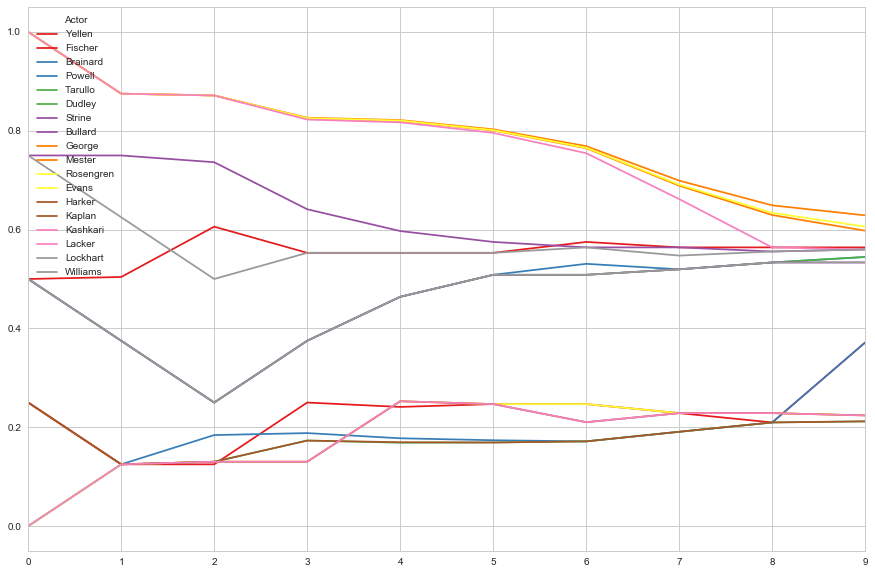

In [11]:
plt.style.use('seaborn-whitegrid')
results.plot(figsize=(15,10), colormap='Set1')